In [344]:
import numpy as np
import matplotlib.pyplot as plt
import math

###Activation Functions

In [345]:
def sigmoid(x):
  return 1/(1 + np.exp(-x))

def d_sigmoid(x):
  return (1 - sigmoid(x)) * sigmoid(x)

def tanh(x):
  return np.tanh(x)

def d_tanh(x):
    return 1 - np.square(np.tanh(x))

def relu(x):
  return np.where(np.asarray(x) > 0, x, 0)

def d_relu(x):
    return np.where(x <= 0, 0, 1)

def softmax(x):
    e_x = np.exp(x)
    return e_x/e_x.sum()

###Cost Function:

In [346]:
def cross_entropy_loss(y, y_hat, i):
  return -np.log(y_hat[y[i]][0])

In [347]:
def cost(y, y_hat, i):
  
  m = y.shape[0]
  c = (1/m) * np.sum(cross_entropy_loss(y, y_hat))
  c = np.squeeze(c) 

  return c

###Layer Class : parameters initialization for each layer

In [348]:
class Layer:

    activationFunc = {
        'tanh': (tanh, d_tanh),
        'sigmoid': (sigmoid, d_sigmoid),
        'relu' : (relu, d_relu),
        'softmax' : (softmax, None)
    }

    def __init__(self, inputs, neurons, activation):
        np.random.seed(33)
        self.W = np.random.randn(neurons, inputs)
        self.b = np.zeros((neurons, 1))
        self.act, self.d_act = self.activationFunc.get(activation)
        self.dW = 0
        self.db = 0

### Forward propagation

In [349]:
def forward_propagation(h, layers):
  m = len(layers)
  
  layers[0].a = np.dot(layers[0].W, h)
  layers[0].h = layers[0].act(layers[0].a)
  #print(layers[0].h.shape)
  
  for j in range(1, m-1):
    layers[j].a = np.dot(layers[j].W, layers[j-1].h)
    layers[j].h = layers[j].act(layers[j].a)
    #print(layers[j].h.shape)

  j+=1
  layers[j].a = np.dot(layers[j].W, layers[j-1].h)
  layers[j].h = softmax(layers[j].a)
  #print(layers[j].h.shape)

  return layers[m-1].h

###Backward_propagation

In [350]:
def backward_propagation(l, y_hat, layers, inp):
  
  #one-hot vector
  e_l = np.zeros((y_hat.shape[0], 1))
  e_l[l] = 1
  
  layers[len(layers)-1].da = -(e_l - y_hat)                 #gradient w.r.t activation of last layer (a_L)
  
  for j in range(len(layers)-1, 0, -1):
                        
    layers[j].dW += np.dot(layers[j].da, (layers[j-1].h).T)
    layers[j].db += layers[j].da

    layers[j-1].dh = np.dot((layers[j].W).T, layers[j].da)
    layers[j-1].da = np.multiply(layers[j-1].dh, layers[j-1].d_act(layers[j-1].a))

  layers[0].dW += np.dot(layers[0].da, inp.T)
  layers[0].db += layers[0].da

  return layers


###Gradient Descent

In [351]:
def update_params(learning_rate, layers, batch_size):
  for layer in layers:
    layer.W = layer.W - learning_rate * layer.dW/batch_size
    layer.b = layer.b - learning_rate * layer.db/batch_size

    layer.dW = 0
    layer.db = 0

###SGD / Batch Gradient Descent

In [352]:
def sgd(epochs, layers, learning_rate, x_train, y_train, batch_size):
    
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #stocastic gradient decent
        if (i+1) % batch_size == 0:
          update_params(learning_rate, layers, batch_size)

      costs.append(cost/m)

      print("Cost after epoch " + str(epoch) + " :", cost/m)

    return costs, layers

###Momentum Gradient descent

In [353]:
def mgd(epochs, layers, learning_rate, x_train, y_train, batch_size):

    gamma = 0.9
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      for layer in layers:
        layer.update_W = 0
        layer.update_b = 0

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #momentum gradient decent
        if (i+1) % batch_size == 0:
          for layer in layers:

            layer.update_W = gamma*layer.update_W + learning_rate*layer.dW/batch_size
            layer.update_b = gamma*layer.update_b + learning_rate*layer.dW/batch_size

            layer.W = layer.W - layer.update_W
            layer.b = layer.b - layer.update_b

            layer.dW = 0
            layer.db = 0

            layer.update_W = 0
            layer.update_b = 0


      costs.append(cost/m)

      print("Cost after epoch " + str(epoch) + " :", cost/m)

    return costs, layers

###Nesterov Gradient Descent

In [354]:
def nesterov(epochs, layers, learning_rate, x_train, y_train, batch_size):

    gamma = 0.9
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      for layer in layers:
        layer.update_W = 0
        layer.update_b = 0

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)

        #calculate W_lookaheads
        if (i+1) % batch_size == 0:
          for layer in layers:
            layer.W = layer.W - gamma * layer.update_W
            layer.b = layer.b - gamma * layer.update_b

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #nesterov gradient decent
        if (i+1) % batch_size == 0:
          for layer in layers:

            layer.update_W = gamma*layer.update_W + learning_rate*layer.dW/batch_size
            layer.update_b = gamma*layer.update_b + learning_rate*layer.dW/batch_size

            layer.W = layer.W - layer.update_W
            layer.b = layer.b - layer.update_b

            layer.dW = 0
            layer.db = 0

            layer.update_W = 0
            layer.update_b = 0

      costs.append(cost/m)
      print("Cost after epoch " + str(epoch) + " :", cost/m)
      
    return costs, layers  

###RMSProp

In [355]:
def rmsprop(epochs, layers, learning_rate, x_train, y_train, batch_size):

    epsilon, beta = 1e-8, 0.9
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      for layer in layers:
        layer.update_W = 0
        layer.update_b = 0

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #rmsprop gradient decent
        if (i+1) % batch_size == 0:
          for layer in layers:

            layer.update_W = beta*layer.update_W + (1-beta)*(layer.dW/batch_size)**2
            layer.update_b = beta*layer.update_b + (1-beta)*(layer.db/batch_size)**2

            layer.W = layer.W - (learning_rate / np.sqrt(layer.update_W + epsilon)) * (layer.dW/batch_size)
            layer.b = layer.b - (learning_rate / np.sqrt(layer.update_b + epsilon)) * (layer.db/batch_size)

            layer.dW = 0
            layer.db = 0

            layer.update_W = 0
            layer.update_b = 0


      costs.append(cost/m)

      print("Cost after epoch " + str(epoch) + " :", cost/m)

    return costs, layers

###Adam

In [356]:
def adam(epochs, layers, learning_rate, x_train, y_train, batch_size):

    epsilon, beta1, beta2 = 1e-8, 0.9, 0.99
    t = 0
    
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      for layer in layers:
        layer.m_W, layer.m_b, layer.v_W, layer.v_b, layer.m_W_hat, layer.m_b_hat, layer.v_W_hat, layer.v_b_hat = 0, 0, 0, 0, 0, 0, 0, 0

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #adam gradient decent
        if (i+1) % batch_size == 0:
          t+=1

          for layer in layers:

            layer.m_W = beta1 * layer.m_W + (1-beta1)*layer.dW/batch_size
            layer.m_b = beta1 * layer.m_b + (1-beta1)*layer.db/batch_size

            layer.v_W = beta2 * layer.v_W + (1-beta2)*((layer.dW/batch_size))**2
            layer.v_b = beta2 * layer.v_b + (1-beta2)*((layer.db/batch_size))**2

            layer.m_W_hat = layer.m_W/(1-math.pow(beta1, t))
            layer.m_b_hat = layer.m_b/(1-math.pow(beta1, t))

            layer.v_W_hat = layer.v_W/(1-math.pow(beta2, t))
            layer.v_b_hat = layer.v_b/(1-math.pow(beta2, t))

            layer.W = layer.W - (learning_rate/np.sqrt(layer.v_W_hat + epsilon))*layer.m_W_hat
            layer.b = layer.b - (learning_rate/np.sqrt(layer.v_b_hat + epsilon))*layer.m_b_hat

            layer.dW = 0
            layer.db = 0

            layer.m_W, layer.m_b, layer.v_W, layer.v_b, layer.m_W_hat, layer.m_b_hat, layer.v_W_hat, layer.v_b_hat = 0, 0, 0, 0, 0, 0, 0, 0


      costs.append(cost/m)

      print("Cost after epoch " + str(epoch) + " :", cost/m)

    return costs, layers

###Putting all togather:

####Train Model

In [357]:
def model_train(epochs, learning_rate, x_train, y_train, activation, h_layers, neurons, batch_size = 16):

  layers= [Layer(x_train.shape[1], neurons, activation)]

  for _ in range(0, h_layers-1):
    layers.append(Layer(neurons, neurons, activation))
  layers.append(Layer(neurons, 10, 'softmax'))
  
  #return sgd(epochs, layers, learning_rate, x_train, y_train, batch_size)
  #return mgd(epochs, layers, learning_rate, x_train, y_train, batch_size)
  #return nesterov(epochs, layers, learning_rate, x_train, y_train, batch_size)
  return rmsprop(epochs, layers, learning_rate, x_train, y_train, batch_size)
  #return adam(epochs, layers, learning_rate, x_train, y_train, batch_size)

###Import dataset and putting in appropriate format

In [358]:
from keras.datasets import fashion_mnist
(x_train_org, y_train_org), (x_test_org, y_test_org) = fashion_mnist.load_data()

In [359]:
print("x_train shape: ", x_train_org.shape)
print("y_train shape: ", y_train_org.shape)

x_train shape:  (60000, 28, 28)
y_train shape:  (60000,)


In [360]:
x_train = x_train_org.reshape(x_train_org.shape[0], -1)
y_train = y_train_org

In [361]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print((x_train[0].reshape(784, 1)).shape)

x_train shape:  (60000, 784)
y_train shape:  (60000,)
(784, 1)


###Train Model

In [362]:
epochs = 5
learning_rate = 0.001
activation = 'sigmoid'
h_layers = 5
neurons = 32

costs, layers = model_train(epochs, learning_rate, x_train, y_train, activation, h_layers, neurons)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Cost after epoch 0 : 1.1260610293644548
Cost after epoch 1 : 0.9698389073562047
Cost after epoch 2 : 0.9772540739709472
Cost after epoch 3 : 1.009371061988453
Cost after epoch 4 : 1.0476266612552678


In [363]:
# Making predictions
h = forward_propagation(x_train.T, layers)
print(h)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[[2.68032599e-12 9.86997195e-16 2.43824350e-17 ... 1.61339879e-15
  4.84457208e-12 1.22094847e-09]
 [6.24327526e-13 1.07435666e-17 1.08284251e-12 ... 6.81591112e-17
  1.43516736e-15 1.71312009e-11]
 [1.99043283e-10 2.59964325e-17 3.50783454e-16 ... 2.47165635e-16
  1.76200236e-12 1.28776413e-06]
 ...
 [1.41972924e-08 7.81365828e-21 7.83488208e-18 ... 5.08996833e-19
  1.52707069e-15 1.18366340e-06]
 [2.99944637e-10 4.97076216e-21 2.64876619e-20 ... 1.47760090e-18
  1.95501881e-15 1.38949561e-06]
 [1.57569518e-07 2.57832717e-20 8.75870055e-20 ... 1.96374552e-18
  7.24004805e-15 1.30818935e-07]]


[1.1260610293644548, 0.9698389073562047, 0.9772540739709472, 1.009371061988453, 1.0476266612552678]


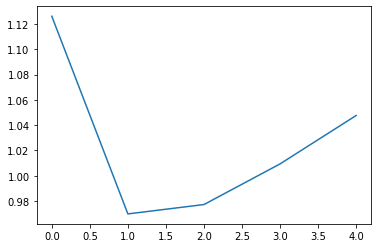

In [364]:
plt.plot(range(epochs), costs)
print(costs)

In [365]:
for layer in layers:
  print(layer.W.shape, layer.b.shape)

(32, 784) (32, 1)
(32, 32) (32, 1)
(32, 32) (32, 1)
(32, 32) (32, 1)
(32, 32) (32, 1)
(10, 32) (10, 1)
